# Porting a NiftyNet model to PyTorch

Introduction, motivation, related works

This notebook gives some low-level intuition about parameters stored in a CNN.

## NiftyNet
<a href="https://niftynet.io/"><img src="https://niftynet.io/img/niftynet-logo.png" alt="drawing" width="150"/>

[NiftyNet](https://niftynet.io/) is "An open source convolutional neural networks platform for medical image analysis and image-guided therapy" built on top of [TensorFlow](https://www.tensorflow.org/).

## HighRes3DNet

HighRes3DNet is a residual convolutional neural network designed to have a large receptive field and preserve a high resolution using a relatively small number of parameters. It was presented in 2017 by Li et al. at IPMI: [*On the Compactness, Efficiency, and Representation of 3D Convolutional Networks: Brain Parcellation as a Pretext Task*](https://arxiv.org/abs/1707.01992).

<img src="images/network.png" alt="drawing" width="600"/>

The authors used [NiftyNet](https://niftynet.io/) to train a model based on this architecture to perform [brain parcellation](https://ieeexplore.ieee.org/document/7086081?arnumber=7086081) from $T_1$-weighted MR images using the [ADNI dataset](http://adni.loni.usc.edu/).

This is an example shown in the paper:

<img src="images/li-000.png" alt="drawing" width="150"/> <img src="images/li-001.png" alt="drawing" width="150"/>

The code of the architecture is on [NiftyNet's GitHub repository](https://github.com/NifTK/NiftyNet/blob/dev/niftynet/network/highres3dnet.py) and the authors have have uploaded thre parameters and configuration file to the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation). After reading the paper and the code, it is more or less straightforward to implement the architecture using PyTorch.

In this notebook we will:

1. Extract the parameters from a TensorFlow checkpoint
2. Transform them to PyTorch
3. Apply the model to some test data



## Setup

### Install and import libraries

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import tempfile
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
from torchsummary import summary

from niftynet.layer.pad import PadLayer
from niftynet.engine.sampler_grid_v2 import GridSampler
from niftynet.engine.windows_aggregator_grid import GridSamplesAggregator
from niftynet.io.image_reader import ImageReader
from niftynet.layer.binary_masking import BinaryMaskingLayer
from niftynet.layer.histogram_normalisation import HistogramNormalisationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer

from highresnet import HighRes3DNet

import tf2pt
import utils
import visualization

INFO:tensorflow:TensorFlow version 1.10.0
INFO:tensorflow:Available Image Loaders:
['nibabel', 'opencv', 'skimage', 'pillow', 'simpleitk', 'dummy'].


### Download NiftyNet data

We can use NiftyNet's [`net_download`](https://niftynet.readthedocs.io/en/dev/model_zoo.html#net-download) to get all we need from the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs):

In [3]:
%%capture
#!net_download highres3dnet_brain_parcellation_model_zoo

In [4]:
niftynet_dir = Path('~/niftynet').expanduser()
utils.list_files(niftynet_dir)

niftynet/
    extensions/
        __init__.py
        network/
            __init__.py
        highres3dnet_brain_parcellation/
            __init__.py
            highres3dnet_config_eval.ini
    models/
        highres3dnet_brain_parcellation/
            settings_inference.txt
            Modality0.csv
            databrain_std_hist_models_otsu.txt
            inference_niftynet_log
            parcellation_output/
                window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz
                inferred.csv
            logs/
            models/
                model.ckpt-33000.meta
                model.ckpt-33000.data-00000-of-00001
                model.ckpt-33000.index
    data/
        OASIS/
            OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz
            license


There are three directories under `~/niftynet`:
1. `extensions` is a Python package and contains the configuration file `highres3dnet_config_eval.ini`
2. `models` contains the landmarks for histogram standardisation and the parameters
3. `data` contains an MRI that can be used to test the model

## Transfer the parameters

### TensorFlow world 
<a href="https://www.tensorflow.org/"><img src="https://static.nvidiagrid.net/ngc/containers/tensorflow.png" alt="drawing" width="50"/>

In [5]:
output_csv_path = 'state_dict_tf.csv'
models_dir = niftynet_dir / 'models'
zoo_entry = 'highres3dnet_brain_parcellation'
checkpoint_name = 'model.ckpt-33000'
checkpoint_path = models_dir / zoo_entry / 'models' / checkpoint_name

state_dict_tf_path = 'state_dict_tf.pth'
state_dict_pt_path = 'state_dict_pt.pth'

pd.set_option('display.max_colwidth', -1)  # do not truncate strings when displaying data frames
pd.set_option('display.max_rows', None)    # show all rows

Let's see what variables are stored in the checkpoint.

Some of them are filtered out by `tf2pt.checkpoint_to_state_dict()` for clarity:
* Variables used by the Adam optimizer during training
* Variables with no shape. They won't help much
* Variables containing `biased` or `ExponentialMovingAverage`. Results using these variables have turned out to be different to the ones produced by NiftyNet

We'll store the TensorFlow variables names in a data frame to list them in this notebook and the values in a Python dictionary to retrieve them later.

In [6]:
data_frame_tf, state_dict_tf = tf2pt.checkpoint_to_state_dict(checkpoint_path)
data_frame_tf

,name,shape
0,conv_0_bn_relu/bn_/beta,16
1,conv_0_bn_relu/bn_/gamma,16
2,conv_0_bn_relu/bn_/moving_mean,16
3,conv_0_bn_relu/bn_/moving_variance,16
4,conv_0_bn_relu/conv_/w,"3, 3, 3, 1, 16"
5,conv_1_bn_relu/bn_/beta,80
6,conv_1_bn_relu/bn_/gamma,80
7,conv_1_bn_relu/bn_/moving_mean,80
8,conv_1_bn_relu/bn_/moving_variance,80
9,conv_1_bn_relu/conv_/w,"1, 1, 1, 64, 80"


The layers names and parameters shapes overall seem to be coherent with the figure in the paper, but there's an additional 1x1x1 convolution with 80 output channels. It's also in the [code](https://github.com/NifTK/NiftyNet/blob/1832a516c909b67d0d9618acbd04a7642c12efca/niftynet/network/highres3dnet.py#L93). It seems to be the model with dropout used in the study to compute the model's uncertainty, so [our implementation of the architecture](https://github.com/fepegar/highresnet/blob/f434266a51924681f95b01a0f03611fbf1148db6/highresnet/highresnet.py#L82-L97) should include this layer as well.

### PyTorch world
<a href="https://pytorch.org/"><img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/pytorch-logo.png" alt="drawing" width="100"/>


In [7]:
num_input_modalities = 1
num_classes = 160
model = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

Let's see what are the names created by PyTorch:

In [8]:
state_dict_pt = model.state_dict()
rows = []
for name, parameters in state_dict_pt.items():
    if 'num_batches_tracked' in name:  # for clarity
        continue
    shape = ', '.join(str(n) for n in parameters.shape)
    row = {'name': name, 'shape': shape}
    rows.append(row)
df_pt = pd.DataFrame.from_dict(rows)
df_pt.style.set_properties(**{'text-align': 'left'})
df_pt

,name,shape
0,block.0.convolutional_block.1.weight,"16, 1, 3, 3, 3"
1,block.0.convolutional_block.2.weight,16
2,block.0.convolutional_block.2.bias,16
3,block.0.convolutional_block.2.running_mean,16
4,block.0.convolutional_block.2.running_var,16
5,block.1.dilation_block.0.residual_block.0.convolutional_block.0.weight,16
6,block.1.dilation_block.0.residual_block.0.convolutional_block.0.bias,16
7,block.1.dilation_block.0.residual_block.0.convolutional_block.0.running_mean,16
8,block.1.dilation_block.0.residual_block.0.convolutional_block.0.running_var,16
9,block.1.dilation_block.0.residual_block.0.convolutional_block.3.weight,"16, 16, 3, 3, 3"


The names and shapes look good and there are 104 lines in both lists, so we should be able to create a mapping between the TensorFlow and the PyTorch variables. 

In [9]:
for name_tf, tensor_tf in state_dict_tf.items():
    shape_tf = tuple(tensor_tf.shape)
    print(f'{str(shape_tf):18}', name_tf) 
    
    # Convert TensorFlow name to PyTorch name
    name_pt, tensor_pt = tf2pt.tf2pt(name_tf, tensor_tf)
    
    shape_pt = tuple(state_dict_pt[name_pt].shape)
    print(f'{str(shape_pt):18}', name_pt)
    
    # Make sure shapes are the same
    if sum(shape_tf) != sum(shape_pt):
        raise ValueError
    
    state_dict_pt[name_pt] = tensor_pt
    print()
print('Saving state dictionary to', state_dict_pt_path)
torch.save(state_dict_pt, state_dict_pt_path)

(16,)              conv_0_bn_relu/bn_/beta
(16,)              block.0.convolutional_block.2.bias

(16,)              conv_0_bn_relu/bn_/gamma
(16,)              block.0.convolutional_block.2.weight

(16,)              conv_0_bn_relu/bn_/moving_mean
(16,)              block.0.convolutional_block.2.running_mean

(16,)              conv_0_bn_relu/bn_/moving_variance
(16,)              block.0.convolutional_block.2.running_var

(3, 3, 3, 1, 16)   conv_0_bn_relu/conv_/w
(16, 1, 3, 3, 3)   block.0.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/beta
(80,)              block.4.convolutional_block.1.bias

(80,)              conv_1_bn_relu/bn_/gamma
(80,)              block.4.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/moving_mean
(80,)              block.4.convolutional_block.1.running_mean

(80,)              conv_1_bn_relu/bn_/moving_variance
(80,)              block.4.convolutional_block.1.running_var

(1, 1, 1, 64, 80)  conv_1_bn_relu/conv_/w
(80

If PyTorch is happy when loading our state dict into the model, we should be on the right track...

In [10]:
model.load_state_dict(state_dict_pt)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

No incompatible keys. Yay!

### Plot weights

Something great about PyTorch is that the modules parameters are easily accesible. Let's plot some of them before and after training:

In [11]:
model_pretrained = model
model_init = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

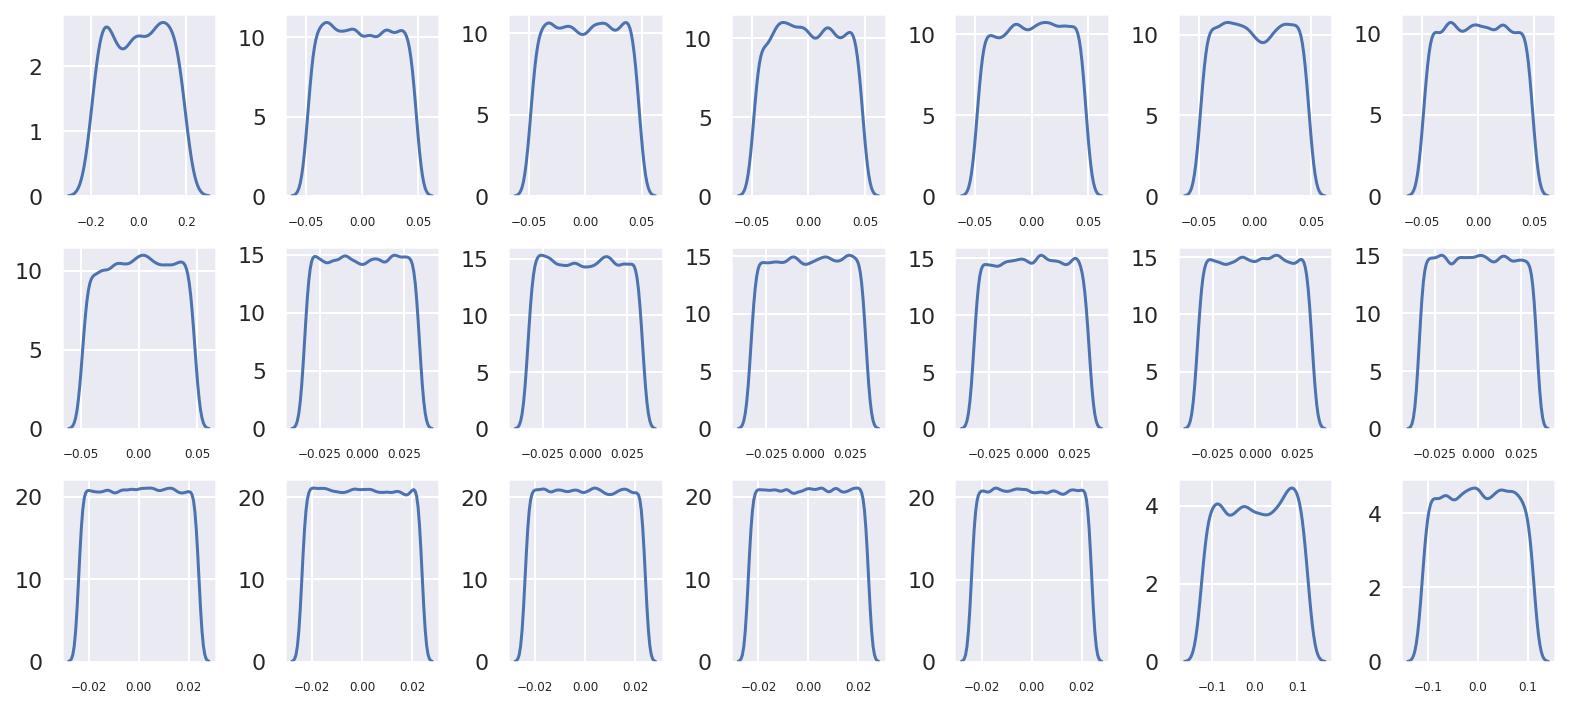

In [12]:
visualization.plot_all_parameters(model_init)

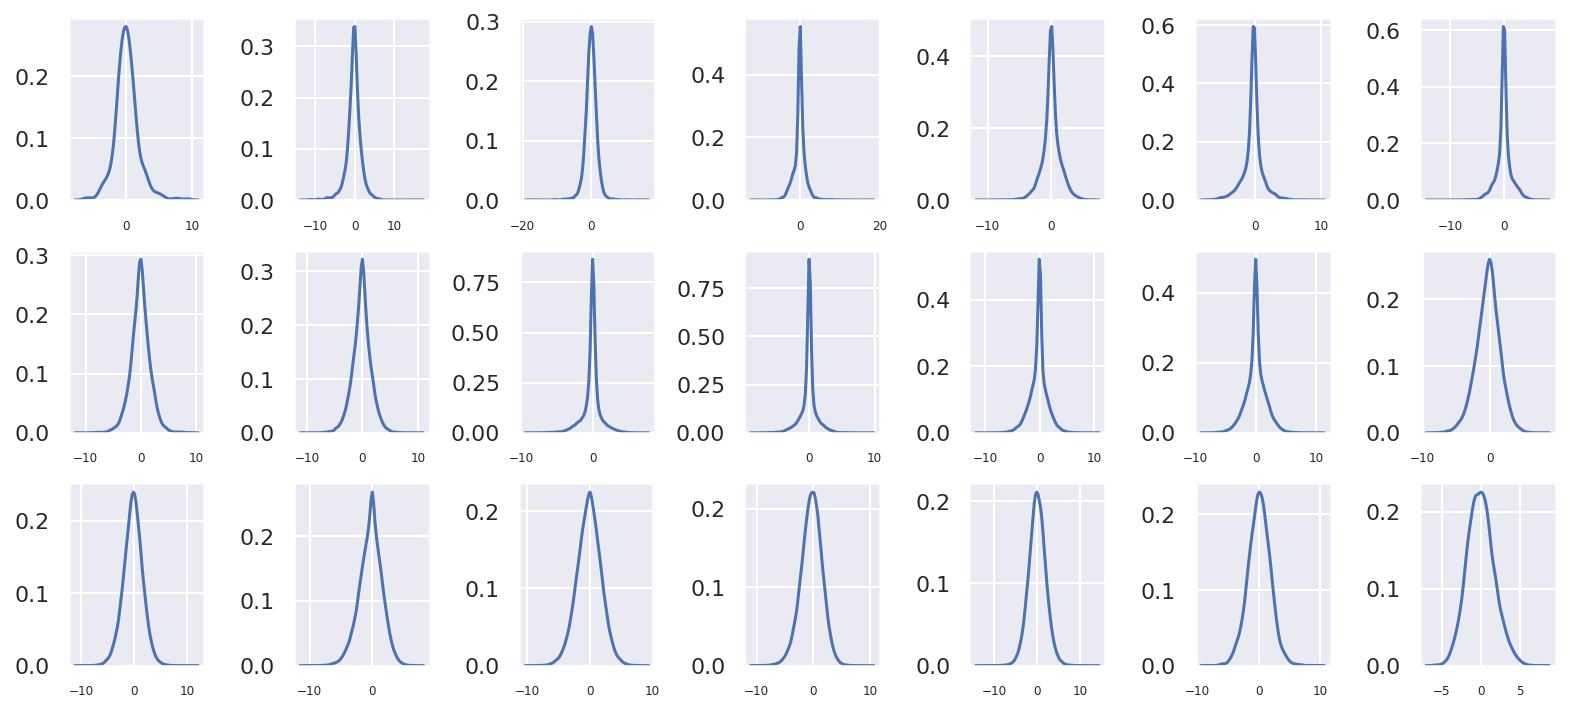

In [13]:
visualization.plot_all_parameters(model_pretrained)

## Run inference

MRI preprocessing must be the same in training and inference. We can figure out the preprocessing from the paper and the configuration file that was downloaded:

```ini
[Modality0]
path_to_search = data/OASIS/
filename_contains = nii
spatial_window_size = (96, 96, 96)
interp_order = 0
pixdim = (1.0, 1.0, 1.0)
axcodes = (R, A, S)

[SYSTEM]
cuda_devices = ""
model_dir = models/highres3dnet_brain_parcellation

[NETWORK]
name = highres3dnet
batch_size = 1
activation_function = relu
volume_padding_size = 10

whitening = True
normalisation = True
normalise_foreground_only=True
foreground_type = mean_plus
histogram_ref_file = databrain_std_hist_models_otsu.txt
cutoff = (0.001, 0.999)


[INFERENCE]
border = 2
inference_iter = 33000
save_seg_dir = ./parcellation_output
output_interp_order = 0
spatial_window_size = (128, 128, 128)


[SEGMENTATION]
image = Modality0
output_prob = False
num_classes = 160
```

NiftyNet offers some powerful I/O tools. We will use NiftyNet's readers, samplers and aggregators to read and write the necessary files. Some of the [demos](https://github.com/NifTK/NiftyNet/tree/dev/demos/module_examples) show how they can be used.

In [14]:
modality_name = 'Modality0'
data_dir = niftynet_dir / 'data' / 'OASIS'
config_path = niftynet_dir / 'extensions' / zoo_entry / 'highres3dnet_config_eval.ini'
config = ConfigParser()
config.read(config_path)
# input_dict = dict(config[modality_name])
# input_dict['path_to_search'] = str(data_dir)
# input_dict['spatial_window_size'] = config['INFERENCE']['spatial_window_size']

['/home/fernando/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini']

In [15]:
window_size = 3 * (128,)
window_border = 3 * (2,)
input_dict = dict(
    path_to_search=str(data_dir),
    filename_contains='nii',
    spatial_window_size=window_size,
    axcodes=('R', 'A', 'S'),
    pixdim=(1, 1, 1),
)
data_parameters = {
    'image': input_dict,
}
reader = ImageReader().initialise(data_parameters)

In [16]:
subject_idx, image_data_dict, interp_order_dict = reader()
image_data_dict['image'].shape

(160, 256, 256, 1, 1)

Looking at the shape of our image, we can say it's now in [RAS+ orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm) and represents 160 sagittal slices, with one channel and one time point.

In [17]:
import importlib
importlib.reload(visualization)

<module 'visualization' from '/home/fernando/git/tf2pt/visualization.py'>

In [18]:
# visualization.plot_volume(image_data_dict['image'])

In [19]:
landmarks_path = models_dir / zoo_entry / 'databrain_std_hist_models_otsu.txt'

reader = ImageReader().initialise(data_parameters)

volume_padding_layer = PadLayer(
    image_name=['image'],  # https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/layer/pad.py#L52
    border=(10, 10, 10),
)

binary_masking_func = BinaryMaskingLayer(type_str='mean_plus')
hist_norm = HistogramNormalisationLayer(
    image_name='image',
    modalities=['Modality0'],
    model_filename=str(landmarks_path),
    binary_masking_func=binary_masking_func,
    cutoff=(0.001, 0.999),
    name='hist_norm_layer',
)
whitening = MeanVarNormalisationLayer(
    image_name='image', binary_masking_func=binary_masking_func)
preprocessing_layers = [
    volume_padding_layer,
    hist_norm,
    whitening,
]
reader.add_preprocessing_layers(preprocessing_layers)

window_size_dict = {'image': window_size}
batch_size = 1
sampler = GridSampler(
    reader,
    window_size_dict,
    window_border=window_border,
)

output_dir = Path(tempfile.gettempdir()) / 'prediction'
output_dir.mkdir(exist_ok=True)

output = GridSamplesAggregator(
    image_reader=reader,
        window_border=window_border,
    output_path=output_dir,
)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()
i = 0
for batch_dict in sampler():
    window = batch_dict['image']
    window = window[..., 0, :]  # remove time dimension
    
    # NN to PT
    window = np.transpose(window, (0, 4, 1, 2, 3))

    # https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
    window = torch.from_numpy(window.copy()).to(device)
    
    with torch.no_grad():
        outputs = model(window)
    outputs = outputs.cpu()
    labels = outputs.argmax(dim=1, keepdim=True).numpy()
    labels = labels.astype(np.uint16)
    labels = np.transpose(labels, (0, 2, 3, 4, 1))
    
    window_dict = dict(window=labels)
    output.decode_batch(window_dict, batch_dict['image_location'])

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 5.94 GiB total capacity; 139.18 MiB already allocated; 152.31 MiB free; 12.82 MiB cached)

Visualize activations

Run inference